In [1]:
%cd ..
%pwd
%env TF_CPP_MIN_LOG_LEVEL=2

/home/faan/Project/dous/codes4emnlp2020_xiuyichen
env: TF_CPP_MIN_LOG_LEVEL=2


In [3]:
import os
import math
from pprint import PrettyPrinter
import random
import numpy as np

import torch  # Torch must be imported before sklearn and tf
import sklearn
import tensorflow as tf
import better_exceptions
from tqdm import tqdm, trange
import colorlog
import colorful

from utils.etc_utils import set_logger, set_tcmalloc, set_gpus, check_none_gradients
from utils import config_utils, custom_argparsers
from models import MODELS
from modules.checkpoint_tracker import CheckpointTracker
from modules.trainer import run_wow_evaluation, Trainer
from modules.from_parlai import download_from_google_drive, unzip
from data.wizard_of_wikipedia import WowDatasetReader
from data.holle import HolleDatasetReader
from data.pchatkg import PchatKGDatasetReader

better_exceptions.hook()
_command_args = config_utils.CommandArgs()
pprint = PrettyPrinter().pprint
pformat = PrettyPrinter().pformat
BEST_N_CHECKPOINTS = 5


# Argument passing/parsing
args, model_args = config_utils.jupyter_initialize_argparser(
    MODELS, _command_args, custom_argparsers.DialogArgumentParser, [
        "--cfg", "ymls/default.yml",
        "--gpus", "0",
        "--test_mode", "wow",
        "--enable_function", "False",
        "--test_ckpt", "./checkpoints/pchat/SequentialKnowledgeTransformer/20211222150124_rerun/ckpt-1290000",
        "SequentialKnowledgeTransformer"
    ])
hparams, hparams_dict = config_utils.create_or_load_hparams(
    args, model_args, args.cfg)
pprint(hparams_dict)
ckpt_fname = os.path.join('./', hparams.test_ckpt)


argskg, model_argskg = config_utils.jupyter_initialize_argparser(
    MODELS, _command_args, custom_argparsers.DialogArgumentParser, [
        "--cfg", "ymls/default.yml",
        "--gpus", "0",
        "--test_mode", "wow",
        "--enable_function", "False",
        "--test_ckpt", "./checkpoints/pchat/SKT_KG/20211227032704_rerun/ckpt-3780000",
        # "--test_ckpt", "./checkpoints/pchat/SKT_KG/2022-05-31-19-29-25_rerun/ckpt-2207616",
        "SKT_KG"
    ])
hparams_kg, hparams_dict_kg = config_utils.create_or_load_hparams(
    argskg, model_argskg, argskg.cfg)
ckpt_fname_kg = os.path.join('./', hparams_kg.test_ckpt)


# Set environment variables & gpus
set_logger()
set_gpus(hparams.gpus)
set_tcmalloc()
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus, 'GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Set random seed
tf.random.set_seed(hparams.random_seed)
np.random.seed(hparams.random_seed)
random.seed(hparams.random_seed)
mirrored_strategy = None

# Make dataset reader
os.makedirs(hparams.cache_dir, exist_ok=True)
if hparams.data_name == 'wizard_of_wikipedia':
    reader_cls = WowDatasetReader
elif hparams.data_name == 'holle':
    reader_cls = HolleDatasetReader
elif hparams.data_name == "pchat":
    reader_cls = PchatKGDatasetReader
else:
    raise ValueError("data_name must be one of 'wizard_of_wikipedia' and 'holle'")
reader = reader_cls(
    # hparams.batch_size, hparams.num_epochs,
    1, hparams.num_epochs,
    buffer_size=hparams.buffer_size,
    bucket_width=hparams.bucket_width,
    max_length=hparams.max_length,
    max_episode_length=hparams.max_episode_length,
    max_knowledge=hparams.max_knowledge,
    knowledge_truncate=hparams.knowledge_truncate,
    cache_dir=hparams.cache_dir,
    # bert_dir=hparams.bert_dir,
    bert_dir='bert_pretrained/chinese_L-12_H-768_A-12',
)
train_dataset, iters_in_train = reader.read('train', mirrored_strategy)
test_dataset, iters_in_test = reader.read('test', mirrored_strategy)
if hparams.data_name == 'wizard_of_wikipedia':
    unseen_dataset, iters_in_unseen = reader.read('test_unseen', mirrored_strategy)
vocabulary = reader.vocabulary

# Build model & optimizer & trainer
model = MODELS[hparams.model](hparams, vocabulary)
optimizer = tf.keras.optimizers.Adam(learning_rate=hparams.init_lr,
                                        clipnorm=hparams.clipnorm)
trainer = Trainer(model, optimizer, mirrored_strategy,
                    hparams.enable_function,
                    reader_cls.remove_pad)


# fake my model
adj, unsupervise_train_dataset, iters_in_uns_train = reader.build_graph_dataset() # get adj_list and dataset
model_kg = MODELS[hparams_kg.model](hparams_kg, vocabulary, adj)
optimizer_kg = tf.keras.optimizers.Adam(learning_rate=hparams_kg.init_lr,
                                            clipnorm=hparams_kg.clipnorm)
trainer_kg = Trainer(model_kg, optimizer_kg, mirrored_strategy,
                    hparams.enable_function,
                    reader_cls.remove_pad)


# Setup checkpoint
global_step = tf.compat.v1.train.get_or_create_global_step()
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                    model=model,
                                    optimizer_step=global_step)
checkpoint_kg = tf.train.Checkpoint(optimizer=optimizer_kg,
                                    model=model_kg,
                                    optimizer_step=global_step)

# Load
train_example = next(iter(train_dataset))
_ = trainer.train_step(train_example)
_ = trainer_kg.train_step(train_example)
#checkpoint.restore(ckpt_fname).assert_consumed()
#checkpoint.restore(ckpt_fname).expect_partial()
# a = model.layers[10].get_weights()
checkpoint.restore(ckpt_fname)
checkpoint_kg.restore(ckpt_fname_kg)
# b = model.layers[10].get_weights()

# # Test
# test_loop_outputs = trainer.test_loop(test_dataset, iters_in_test, 0, 'seen')
# if hparams.data_name == 'wizard_of_wikipedia':
#     unseen_loop_outputs = trainer.test_loop(unseen_dataset, iters_in_unseen, 0, 'unseen')

# test_summaries, log_dict = run_wow_evaluation(
#     test_loop_outputs, hparams.test_ckpt, 'test')
#     # test_loop_outputs, hparams.checkpoint_dir, 'seen')
# if hparams.data_name == 'wizard_of_wikipedia':
#     unseen_summaries, unseen_log_dict = run_wow_evaluation(
#         unseen_loop_outputs, hparams.checkpoint_dir, 'unseen')

# # Logging
# tqdm.write(colorful.bold_green("seen").styled_string)
# tqdm.write(colorful.bold_red(pformat(log_dict)).styled_string)
# if hparams.data_name == 'wizard_of_wikipedia':
#     tqdm.write(colorful.bold_green("unseen").styled_string)
#     tqdm.write(colorful.bold_red(pformat(unseen_log_dict)).styled_string)

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!
[WARNING:2023-03-30 21:07:06] /usr/lib/libtcmalloc.so not exists. There might be performance loss when you use data parallelism
[INFO:2023-03-30 21:07:06] Load cached pchatkg from cached/pchatkg/train_episodes.json


2023-03-30-21-07-06
{'default': {'batch_size': 1,
             'bert_dir': 'bert_pretrained/uncased_L-12_H-768_A-12',
             'bucket_width': 5,
             'buffer_size': 10000,
             'cache_dir': 'cached',
             'cfg': 'ymls/default.yml',
             'checkpoint_base_dir': 'checkpoints',
             'checkpoint_dir': 'checkpoints/pchat/SequentialKnowledgeTransformer/2023-03-30-21-07-06_rerun',
             'clipnorm': 0.4,
             'data_name': 'pchat',
             'embedding_dropout': 0.2,
             'enable_function': False,
             'evaluation_epoch': 1.0,
             'gpus': '0',
             'ignore_none_gradients': True,
             'init_lr': 2e-05,
             'keep_best_checkpoint': True,
             'knowledge_label_smoothing': 0.1,
             'knowledge_teacher_forcing': False,
             'knowledge_truncate': 32,
             'logging_step': 20,
             'lr_decay_factor': 1.0,
             'max_episode_length': 5,
           

[INFO:2023-03-30 21:07:17] Construct datagenerator
[INFO:2023-03-30 21:07:17] Shuffle traning set
[INFO:2023-03-30 21:07:17] Padding parsing
[INFO:2023-03-30 21:07:17] Reading dataset finished.
[INFO:2023-03-30 21:07:17] Load cached pchatkg from cached/pchatkg/test_episodes.json
[INFO:2023-03-30 21:07:17] Construct datagenerator
[INFO:2023-03-30 21:07:17] Padding parsing
[INFO:2023-03-30 21:07:17] Reading dataset finished.
[WARNING:2023-03-30 21:07:22] Use pointer-generator mechanism.                              Note that output is not logit but softmax.
[ERROR:2023-03-30 21:07:22] bert_model_2/pooler_transform/kernel:0 has None gradient!
[ERROR:2023-03-30 21:07:22] bert_model_2/pooler_transform/bias:0 has None gradient!


[WARNING:2023-03-30 21:07:22] Gradients do not exist for variables ['bert_model_2/pooler_transform/kernel:0', 'bert_model_2/pooler_transform/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[WARNING:2023-03-30 21:07:24] Use pointer-generator mechanism.                              Note that output is not logit but softmax.
[ERROR:2023-03-30 21:07:24] bert_model_3/pooler_transform/kernel:0 has None gradient!
[ERROR:2023-03-30 21:07:24] bert_model_3/pooler_transform/bias:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variable:0 has None gradient!
[ERROR:2023-03-30 21:07:24] Variab

[WARNING:2023-03-30 21:07:25] Gradients do not exist for variables ['bert_model_3/pooler_transform/kernel:0', 'bert_model_3/pooler_transform/bias:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


In [2]:
import os
import math
from pprint import PrettyPrinter
import random
import numpy as np

import torch  # Torch must be imported before sklearn and tf
import sklearn
import tensorflow as tf
import better_exceptions
from tqdm import tqdm, trange
import colorlog
import colorful

from utils.etc_utils import set_logger, set_tcmalloc, set_gpus, check_none_gradients
from utils import config_utils, custom_argparsers
from models import MODELS
from modules.checkpoint_tracker import CheckpointTracker
from modules.trainer import run_wow_evaluation, Trainer
from modules.from_parlai import download_from_google_drive, unzip
from data.wizard_of_wikipedia import WowDatasetReader
from data.holle import HolleDatasetReader
from data.pchatkg import PchatKGDatasetReader

better_exceptions.hook()
_command_args = config_utils.CommandArgs()
pprint = PrettyPrinter().pprint
pformat = PrettyPrinter().pformat
BEST_N_CHECKPOINTS = 5


# Argument passing/parsing
args, model_args = config_utils.jupyter_initialize_argparser(
    MODELS, _command_args, custom_argparsers.DialogArgumentParser, [
        "--cfg", "ymls/default.yml",
        "--gpus", "0",
        "--test_mode", "wow",
        "--test_ckpt", "./checkpoints/pchat/SequentialKnowledgeTransformer/20211222150124_rerun/ckpt-1290000",
        "SequentialKnowledgeTransformer"
    ])
argskg, model_argskg = config_utils.jupyter_initialize_argparser(
    MODELS, _command_args, custom_argparsers.DialogArgumentParser, [
        "--cfg", "ymls/default.yml",
        "--gpus", "0",
        "--test_mode", "wow",
        "--test_ckpt", "./checkpoints/pchat/SKT_KG/20211227032704_rerun/ckpt-3780000",
        "SKT_KG"
    ])
hparams, hparams_dict = config_utils.create_or_load_hparams(
    args, model_args, args.cfg)
hparams_kg, hparams_dict_kg = config_utils.create_or_load_hparams(
    argskg, model_argskg, argskg.cfg)
pprint(hparams_dict)

ckpt_fname = os.path.join('./', hparams.test_ckpt)
ckpt_fname_kg = os.path.join('./', hparams_kg.test_ckpt)


# Set environment variables & gpus
set_logger()
set_gpus(hparams.gpus)
set_tcmalloc()
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus, 'GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Set random seed
tf.random.set_seed(hparams.random_seed)
np.random.seed(hparams.random_seed)
random.seed(hparams.random_seed)
mirrored_strategy = None

# Make dataset reader
os.makedirs(hparams.cache_dir, exist_ok=True)
if hparams.data_name == 'wizard_of_wikipedia':
    reader_cls = WowDatasetReader
elif hparams.data_name == 'holle':
    reader_cls = HolleDatasetReader
elif hparams.data_name == "pchat":
    reader_cls = PchatKGDatasetReader
else:
    raise ValueError("data_name must be one of 'wizard_of_wikipedia' and 'holle'")
reader = reader_cls(
    # hparams.batch_size, hparams.num_epochs,
    1, hparams.num_epochs,
    buffer_size=hparams.buffer_size,
    bucket_width=hparams.bucket_width,
    max_length=hparams.max_length,
    max_episode_length=hparams.max_episode_length,
    max_knowledge=hparams.max_knowledge,
    knowledge_truncate=hparams.knowledge_truncate,
    cache_dir=hparams.cache_dir,
    # bert_dir=hparams.bert_dir,
    bert_dir='bert_pretrained/chinese_L-12_H-768_A-12',
)
train_dataset, iters_in_train = reader.read('train', mirrored_strategy)
test_dataset, iters_in_test = reader.read('test', mirrored_strategy)
if hparams.data_name == 'wizard_of_wikipedia':
    unseen_dataset, iters_in_unseen = reader.read('test_unseen', mirrored_strategy)
vocabulary = reader.vocabulary

# Build model & optimizer & trainer
if mirrored_strategy:
    with mirrored_strategy.scope():
        model = MODELS[hparams.model](hparams, vocabulary)
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams.init_lr,
                                                clipnorm=hparams.clipnorm)
else:
    model = MODELS[hparams.model](hparams, vocabulary)
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams.init_lr,
                                            clipnorm=hparams.clipnorm)
trainer = Trainer(model, optimizer, mirrored_strategy,
                    hparams.enable_function,
                    reader_cls.remove_pad)




# fake my model
model_kg = MODELS[hparams_kg.model](hparams_kg, vocabulary)
optimizer_kg = tf.keras.optimizers.Adam(learning_rate=hparams_kg.init_lr,
                                            clipnorm=hparams_kg.clipnorm)
trainer_kg = Trainer(model_kg, optimizer_kg, mirrored_strategy,
                    hparams.enable_function,
                    reader_cls.remove_pad)


# Setup checkpoint
global_step = tf.compat.v1.train.get_or_create_global_step()
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                    model=model,
                                    optimizer_step=global_step)
checkpoint_kg = tf.train.Checkpoint(optimizer=optimizer_kg,
                                    model=model_kg,
                                    optimizer_step=global_step)

# Load
train_example = next(iter(train_dataset))
_ = trainer.train_step(train_example)
_ = trainer_kg.train_step(train_example)
#checkpoint.restore(ckpt_fname).assert_consumed()
#checkpoint.restore(ckpt_fname).expect_partial()
# a = model.layers[10].get_weights()
checkpoint.restore(ckpt_fname)
checkpoint_kg.restore(ckpt_fname_kg)
# b = model.layers[10].get_weights()

# # Test
# test_loop_outputs = trainer.test_loop(test_dataset, iters_in_test, 0, 'seen')
# if hparams.data_name == 'wizard_of_wikipedia':
#     unseen_loop_outputs = trainer.test_loop(unseen_dataset, iters_in_unseen, 0, 'unseen')

# test_summaries, log_dict = run_wow_evaluation(
#     test_loop_outputs, hparams.test_ckpt, 'test')
#     # test_loop_outputs, hparams.checkpoint_dir, 'seen')
# if hparams.data_name == 'wizard_of_wikipedia':
#     unseen_summaries, unseen_log_dict = run_wow_evaluation(
#         unseen_loop_outputs, hparams.checkpoint_dir, 'unseen')

# # Logging
# tqdm.write(colorful.bold_green("seen").styled_string)
# tqdm.write(colorful.bold_red(pformat(log_dict)).styled_string)
# if hparams.data_name == 'wizard_of_wikipedia':
#     tqdm.write(colorful.bold_green("unseen").styled_string)
#     tqdm.write(colorful.bold_red(pformat(unseen_log_dict)).styled_string)

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/namedlist.py:252: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(field_names, _collections.Mapping):
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/namedlist.py:423: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  _collections.Sequence.register(t)
[WARNING:2023-03-30 21:03:47] /usr/lib/libtcmalloc.so not exists. There might be performance loss when you use data parallelism
[INFO:2023-03-30 21:03:47] Load cached pchatkg from cached/pchatkg/train_episodes.json


2023-03-30-21-03-47
2023-03-30-21-03-47
{'default': {'batch_size': 1,
             'bert_dir': 'bert_pretrained/uncased_L-12_H-768_A-12',
             'bucket_width': 5,
             'buffer_size': 10000,
             'cache_dir': 'cached',
             'cfg': 'ymls/default.yml',
             'checkpoint_base_dir': 'checkpoints',
             'checkpoint_dir': 'checkpoints/pchat/SequentialKnowledgeTransformer/2023-03-30-21-03-47_rerun',
             'clipnorm': 0.4,
             'data_name': 'pchat',
             'embedding_dropout': 0.2,
             'enable_function': True,
             'evaluation_epoch': 1.0,
             'gpus': '0',
             'ignore_none_gradients': True,
             'init_lr': 2e-05,
             'keep_best_checkpoint': True,
             'knowledge_label_smoothing': 0.1,
             'knowledge_teacher_forcing': False,
             'knowledge_truncate': 32,
             'logging_step': 20,
             'lr_decay_factor': 1.0,
             'max_episode_leng

[INFO:2023-03-30 21:03:57] Construct datagenerator
[INFO:2023-03-30 21:03:58] Shuffle traning set
[INFO:2023-03-30 21:03:58] Padding parsing
[INFO:2023-03-30 21:03:58] Reading dataset finished.
[INFO:2023-03-30 21:03:58] Load cached pchatkg from cached/pchatkg/test_episodes.json
[INFO:2023-03-30 21:03:58] Construct datagenerator
[INFO:2023-03-30 21:03:58] Padding parsing
[INFO:2023-03-30 21:03:58] Reading dataset finished.


[WARNING:2023-03-30 21:04:00] From /home/faan/Project/dous/codes4emnlp2020_xiuyichen/modules/rnn.py:15: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[WARNING:2023-03-30 21:04:08] Use pointer-generator mechanism.                              Note that output is not logit but softmax.
[WARNING:2023-03-30 21:04:09] AutoGraph could not transform <bound method Socket.send of <zmq.Socket(zmq.PUSH) at 0x7fe8bc3b9460>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[ERROR:2023-03-30 21:04:14] bert_model/pooler_transform/kernel:0 has None gradient!
[ERROR:2023-03-30 21:04:14] bert_model/pooler_transform/bias:0 has None gradient!


[WARNING:2023-03-30 21:04:14] Gradients do not exist for variables ['bert_model/pooler_transform/kernel:0', 'bert_model/pooler_transform/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[WARNING:2023-03-30 21:04:20] Use pointer-generator mechanism.                              Note that output is not logit but softmax.
[ERROR:2023-03-30 21:04:27] bert_model/pooler_transform/kernel:0 has None gradient!
[ERROR:2023-03-30 21:04:27] bert_model/pooler_transform/bias:0 has None gradient!


[WARNING:2023-03-30 21:04:27] Gradients do not exist for variables ['bert_model/pooler_transform/kernel:0', 'bert_model/pooler_transform/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


TypeError: in user code:

    File "/home/faan/Project/dous/codes4emnlp2020_xiuyichen/modules/trainer.py", line 132, in _train_step  *
        output_dict = model(example)
    File "/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "SKT_KG" (type SKT_KG).
    
    in user code:
    
        File "/home/faan/Project/dous/codes4emnlp2020_xiuyichen/models/sequential_knowledge_transformer.py", line 435, in call  *
            con_nodes_features = self.global_gnn(node_index, self.concept_embeddings_layer)
        File "/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "global_sage" (type GlobalSage).
        
        in user code:
        
            File "/home/faan/Project/dous/codes4emnlp2020_xiuyichen/models/graphsage.py", line 79, in call  *
                for i in self.adj:
        
            TypeError: 'NoneType' object is not iterable
        
        
        Call arguments received:
          • nodes=tf.Tensor(shape=(None,), dtype=int32)
          • embedding=<keras.layers.embeddings.Embedding object at 0x7fe6245ee070>
    
    
    Call arguments received:
      • inputs={'episode_length': 'tf.Tensor(shape=(1,), dtype=int32)', 'context_length': 'tf.Tensor(shape=(1, None), dtype=int32)', 'response_length': 'tf.Tensor(shape=(1, None), dtype=int32)', 'chosen_topic_length': 'tf.Tensor(shape=(1, None), dtype=int32)', 'num_knowledge_sentences': 'tf.Tensor(shape=(1, None), dtype=int32)', 'context': 'tf.Tensor(shape=(1, None, None), dtype=int32)', 'response': 'tf.Tensor(shape=(1, None, None), dtype=int32)', 'chosen_topic': 'tf.Tensor(shape=(1, None, None), dtype=int32)', 'knowledge_sentences_length': 'tf.Tensor(shape=(1, None, None), dtype=int32)', 'knowledge_sentences': 'tf.Tensor(shape=(1, None, None, None), dtype=int32)', 'knowledge_kg_masks': 'tf.Tensor(shape=(1, None, None, None), dtype=int32)'}
      • training=True


In [8]:
# TODO: how to get multi examples
# prior, post = model.xxx()
# priors, posts = model.xxxs()
priors = [[],[]]
posts = [[],[]]
priors_args = [[],[]]
posts_args = [[],[]]
examples = []

from collections import defaultdict

results_dict = defaultdict(list)
# num_steps = 10
num_steps = 500
# reader = reader_cls(
#     # hparams.batch_size, hparams.num_epochs,
#     1, hparams.num_epochs,
#     buffer_size=hparams.buffer_size,
#     bucket_width=hparams.bucket_width,
#     max_length=hparams.max_length,
#     max_episode_length=hparams.max_episode_length,
#     max_knowledge=hparams.max_knowledge,
#     knowledge_truncate=hparams.knowledge_truncate,
#     cache_dir=hparams.cache_dir,
#     # bert_dir=hparams.bert_dir,
#     bert_dir='bert_pretrained/chinese_L-12_H-768_A-12',
# )
# train_dataset, iters_in_train = reader.read('train', mirrored_strategy)
dataset = train_dataset
dataset_iter = iter(dataset)        

test_tqdm = tqdm(range(num_steps), ncols=70)
for i, current_step in enumerate(test_tqdm): # actually it's train_iter
    example = next(dataset_iter)

    #step_result = test_step(example)
    example = PchatKGDatasetReader.remove_pad(example)
    examples.append(example)
    
    if tf.math.reduce_sum(example['knowledge_kg_masks'])==0:
        # continue
        pass
    else:
        print('+1')
    
    # predict
    # output_dict = model(example, training=False)
    prior, posterior = model.get_hidden(example)
    prior_attentions, prior_argmaxes = prior
    posterior_attentions, posterior_argmaxes = posterior
    
    priors[0].append(prior_attentions)
    priors_args[0].append(prior_argmaxes)
    posts[0].append(posterior_attentions)
    posts_args[0].append(posterior_argmaxes)

    prior, posterior = model_kg.get_hidden(example)
    prior_attentions, prior_argmaxes = prior
    posterior_attentions, posterior_argmaxes = posterior
    
    priors[1].append(prior_attentions)
    priors_args[1].append(prior_argmaxes)
    posts[1].append(posterior_attentions)
    posts_args[1].append(posterior_argmaxes)
    
    # batch_size = output_dict['num_valid_turns'] if 'num_valid_turns' in output_dict else self._batch_size
    # for key, value in output_dict.items():
    #     if 'loss' in key:
    #         output_dict[key] = tf.reduce_sum(value) * 1. / batch_size
    # for key, value in output_dict.items():
    #     results_dict[key].append(value.numpy())



# for key, value in results_dict.items():
#     if key == 'knowledge_sent_gt':# 变长list of knowledge sentences
#         list_of_know_sent = [j for i in value for j in i]
#         list_of_know_sent = [np.pad(i, ((0,0),(1,0))) for i in list_of_know_sent]
#         results_dict[key] = [np.concatenate(i) for i in list_of_know_sent]
#     elif key == 'knowledge_sent_pred':# 变长knowledge sentences
#         results_dict[key] = [j for i in value for j in i]
#     elif results_dict[key][0].shape == ():
#         results_dict[key] = np.array(value)
#     else:
#         results_dict[key] = np.concatenate(value, axis=0)


100%|███████████████████████████████| 500/500 [05:46<00:00,  1.44it/s]


In [4]:
# priors, priors_args, examples
len(priors[1]), len(priors_args[1]), priors[1][0], priors_args[1][0]

(10,
 10,
 <tf.Tensor: shape=(5, 8), dtype=float32, numpy=
 array([[0.30938414, 0.0144242 , 0.30938414, 0.0144242 , 0.30938414,
         0.01428741, 0.0144242 , 0.01428758],
        [0.9593449 , 0.04065508, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.9449743 , 0.02632467, 0.02870095, 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.9385312 , 0.0199601 , 0.02162794, 0.01988073, 0.        ,
         0.        , 0.        , 0.        ],
        [0.93641627, 0.01548401, 0.01530163, 0.01559015, 0.0172079 ,
         0.        , 0.        , 0.        ]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>)

In [ ]:
examples[0]

{'context': <tf.Tensor: shape=(1, 5, 52), dtype=int32, numpy=
 array([[[ 101, 3308, 7831, 4052, 5673, 4638, 3864, 6163, 5682, 6444,
          8024, 1762,  686, 4518, 5745, 1741, 1079, 6963, 3221, 3683,
          6772, 2208, 6224,  511,  102,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0],
         [ 101, 7434, 6501, 2936, 7608, 4514, 7481, 8024, 2697, 6468,
           782, 5102, 3152, 3209, 8024, 6375, 5318, 1920, 6956, 1146,
           782, 6963, 3187, 7444,  711, 1391,  671, 7561, 7649, 1963,
          3634, 2894, 1462,  102,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0],
         [ 101, 6132, 3302, 1962, 4692, 8024,  782,  738, 5125, 1896,
          2358, 3698, 8024,  852,  711,  784,  720, 2218,  679, 5447,
          4692, 1450, 8043, 1168, 2419, 3221, 1525, 

In [ ]:
examples[0]

{'episode_length': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>,
 'context_length': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[36, 52, 48, 52, 16]], dtype=int32)>,
 'response_length': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[14, 14, 21,  7, 23]], dtype=int32)>,
 'chosen_topic_length': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[3, 3, 3, 3, 3]], dtype=int32)>,
 'num_knowledge_sentences': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[8, 2, 3, 4, 5]], dtype=int32)>,
 'context': <tf.Tensor: shape=(1, 5, 52), dtype=int32, numpy=
 array([[[ 101, 4692,  749,  671,  678, 3297, 6818,  673, 1921, 1357,
          1068, 2769, 4638, 5106,  692, 1154, 6134, 4692, 1168, 1962,
          1914,  686, 4518, 3344, 3309, 7313, 4706, 4225, 4638,  782,
          6820, 2923, 7410, 6814, 4638,  102,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0],
         [ 101,  100, 8198, 2259, 77

In [ ]:
examples[0].keys()

dict_keys(['context', 'response', 'chosen_topic', 'knowledge_sentences', 'knowledge_kg_masks', 'episode_length', 'context_length', 'response_length', 'chosen_topic_length', 'knowledge_sentences_length', 'num_knowledge_sentences', 'knowledge_kg_masks_length', 'num_knowledge_kg_masks'])

In [ ]:
se = reader.vocabulary.index_to_string(examples[0]['context'][0]).numpy()
np.char.decode(se.astype(np.bytes_), 'UTF-8')
se = reader.vocabulary.index_to_string(examples[0]['knowledge_sentences'][0]).numpy()
np.char.decode(se.astype(np.bytes_), 'UTF-8')

array([[['[unused1]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[unused1]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ...,
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]']],

       [['[CLS]', 'null', '[SEP]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[CLS]', '他', '改', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ...,
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[PAD]', '[PAD]', '[PAD]', ..., '[PAD]', '[PAD]', '[PAD]']],

       [['[CLS]', 'null', '[SEP]', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[CLS]', '他', '改', ..., '[PAD]', '[PAD]', '[PAD]'],
        ['[CLS

In [ ]:
def convert(sentence_tensor):
    s_raw = reader.vocabulary.index_to_string(sentence_tensor).numpy()
    s_decode = np.char.decode(s_raw.astype(np.bytes_), 'UTF-8')
    print(s_decode.shape)
    if len(s_decode.shape) == 3:
        result = []
        for i in s_decode:
            tmp_list = []
            for z in i:
                tmp= []
                for j in z:
                    if j == '[SEP]' or j == '[PAD]':
                        break
                    else:
                        tmp.append(j)
                p_sent = ' '.join(tmp)
#                 if p_sent != '':
                tmp_list.append(p_sent)
            result.append(tmp_list)
    elif len(s_decode.shape) == 2:
        result = []
        for i in s_decode:
            tmp= []
            for j in i:
                if j == '[SEP]' or j == '[PAD]':
                    break
                else:
                    tmp.append(j)
            result.append(' '.join(tmp))
    else:
        result = []
        for i in s_decode:
            if i == '[SEP]' or i == '[PAD]':
                break
            else:
                result.append(i)
        result = ' '.join(result)
    return result

i=0 # instance ID
context = convert(examples[0]['context'][i])
knowledge = convert(examples[0]['knowledge_sentences'][i])
response = convert(examples[0]['response'][i])
import pprint
pp = pprint.PrettyPrinter(indent=4)
print('context')
pp.pprint(context)
print('response')
pp.pprint(response)
print('knowledge')
pp.pprint(knowledge)
examples[0]['num_knowledge_sentences'][i]
priors[1][0].shape


(5, 52)
(5, 32, 34)
(5, 52)
context
[   '[CLS] 朝 鲜 潜 艇 的 涂 装 色 调 ， 在 世 界 范 围 内 都 是 比 较 少 见 。',
    '[CLS] 雪 豹 捕 食 画 面 ， 感 谢 人 类 文 明 ， 让 绝 大 部 分 人 都 无 需 为 吃 一 顿 饭 如 此 拼 命',
    '[CLS] 衣 服 好 看 ， 人 也 精 壮 帅 气 ， 但 为 什 么 就 不 耐 看 呢 ？ 到 底 是 哪 里 出 了 问 题 ？',
    '[CLS] 教 宗 怀 着 激 动 的 心 情 亲 切 会 见 两 位 中 国 主 教 。',
    '[CLS] 缅 甸 啤 酒 ， 喝 ！']
response
[   '[CLS] 他 改 变 了 朝 鲜',
    '[CLS] 很 好 很 强 大',
    '[CLS] 图 1 发 现 了 一 个 猥 琐 男',
    '[CLS] 准 备 要 建 交 了 咯',
    '[CLS] 这 是 缅 甸 妹 ？']
knowledge
[   [   '[unused1]',
        '',
        '[unused1]',
        '',
        '[unused1]',
        '[unused2]',
        '',
        '[unused8]',
        '[unused3]',
        '',
        '[unused1]',
        '',
        '[unused2]',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        '',
        ''],
    [   '[CLS] null',
        '[CLS] 他 改 变 了 朝 鲜',
        '',

TensorShape([5, 8])

In [ ]:
from data import vocabulary as data_vocab

def _trim_after_eos(sentences, replace_unk=False, mask=None):
    if mask is not None:
        # print(sentences)
        # print(mask)
        # print(sentences.shape)
        # print(mask.shape)

        assert len(sentences) == len(mask), "sentences and mask should have same length"

    trimmed_sentences = []
    
    replace_pad = False
    if sentences[0][0] == 0:
        replace_pad = True
        
    for i, sentence in enumerate(sentences):
        if mask is not None and not mask[i]:
            continue
        # Convert bytes array to utf-8 array
        sentence = np.char.decode(sentence.astype(np.bytes_), 'UTF-8')

        try:
            if replace_pad:
                eos_idx = int(np.where(sentence == data_vocab._BERT_SEP)[0][-1])
                trimmed_sentence = ' '.join(sentence[1:eos_idx])
            else:
                eos_idx = int(np.where(sentence == data_vocab._BERT_SEP)[0][0])
                trimmed_sentence = ' '.join(sentence[:eos_idx])
        except IndexError:
            trimmed_sentence = ' '.join(sentence)

        if replace_unk:
            trimmed_sentence = trimmed_sentence.replace(data_vocab._BERT_UNK, '_[UNK]')
        if replace_pad:
            trimmed_sentence = trimmed_sentence.replace(data_vocab._BERT_PAD, '')

        trimmed_sentences.append(trimmed_sentence)
    return trimmed_sentences

examples[0]
# answers = trim_fn(results_dict['answers'], mask=episode_mask)

{'context': <tf.Tensor: shape=(1, 5, 52), dtype=int32, numpy=
 array([[[ 101, 4692,  749,  671,  678, 3297, 6818,  673, 1921, 1357,
          1068, 2769, 4638, 5106,  692, 1154, 6134, 4692, 1168, 1962,
          1914,  686, 4518, 3344, 3309, 7313, 4706, 4225, 4638,  782,
          6820, 2923, 7410, 6814, 4638,  102,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0],
         [ 101,  100, 8198, 2259, 7770, 7977, 4638,  800, 3341, 1168,
          5739, 6631, 8024, 6820, 5543, 5326, 5330, 1355, 2916,  868,
          4500,  720, 8043,  100,  800, 4500, 6134, 4385, 6395, 3209,
           749, 1762,  800, 4638, 2099, 1073, 7027, 8024, 3766, 3300,
          7770, 7977, 8024, 3766, 3300,  100, 6820, 5543,  100,  720,
          8043,  100],
         [ 101, 6819, 1726, 5665, 2571, 2970, 6239, 1765, 7481, 3198,
           833, 6822, 6121,  671, 3613, 4157, 4125, 8024,  772, 4495,
          4638, 1353, 2972, 1213, 1377,  809, 6629, 

In [ ]:
len(posts[0])

0

In [14]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# Importing seaborn to make nice plots.
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# An user defined function to create scatter plot of vectors
def scatter(x, colors, name):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=20,
                    c=palette[colors.astype(np.int)])
    plt.xlim(x.min()*1.1, x.max()*1.1)
    plt.ylim(x.min()*1.1, x.max()*1.1)
    #ax.axis('off')
    #ax.axis('tight')

    plt.savefig(name+'.svg', format='svg')
    plt.show()

    # We add the labels for each cluster.
    """"
    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    """
    return f, ax, sc

# for i in range(users.shape[0]):
#     dis=avalues_dense[all_h_list[all_h_list==i],all_t_list[[all_h_list==i]],:].max(1)[1]
#     users_45=users[i]
#     u45_items=items[all_t_list[[all_h_list==i]]]
#     u45_items=torch.stack([u45_items[i,dis[i]*16:dis[i]*16+16] for i in range(u45_items.shape[0])])
#     item_embedded = TSNE(n_components=2).fit_transform(u45_items)
#     f, ax, sc=scatter(item_embedded, dis.numpy())
#     #f.savefig('pic/user/'+str(i)+'.png', dpi=100)

def myprint(item, color, name='none'):
    item_embedded = TSNE(n_components=2).fit_transform(item)
    f, ax, sc=scatter(item_embedded, color, name)

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_3128386/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/env

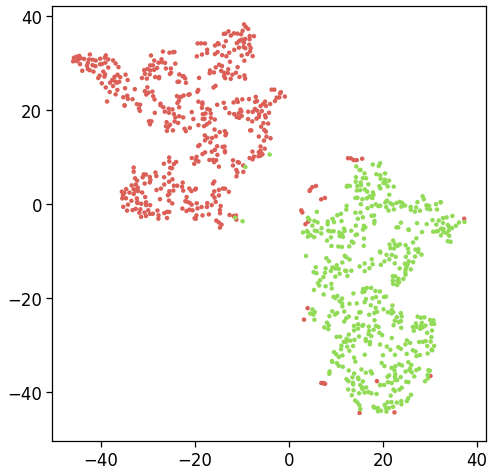

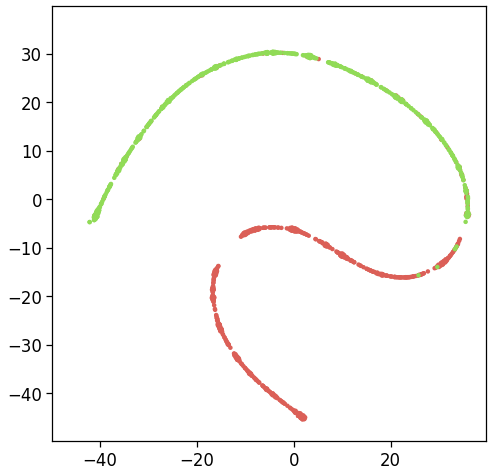

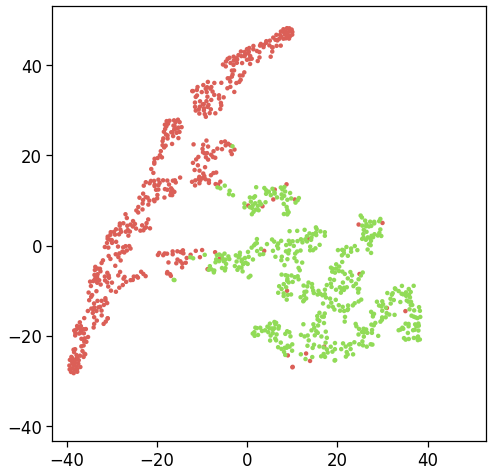

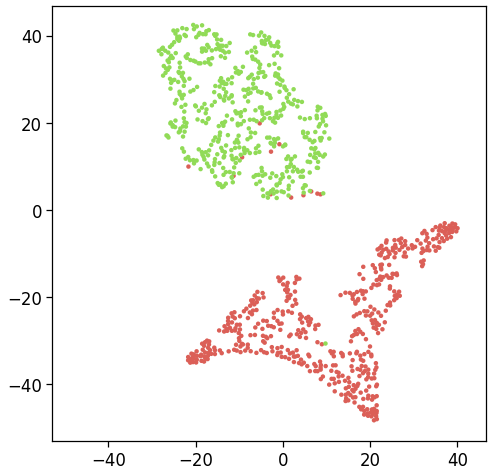

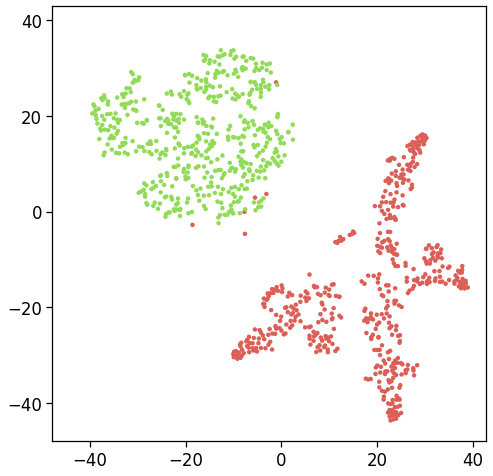

In [ ]:
# initialized original per episode
color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])
for i in range(5):
    item_pri = np.array(priors[0])[:,i,:]
    item_post = np.array(posts[0])[:,i,:]
    item = np.concatenate((item_pri,item_post), axis=0)
    item.shape
    myprint(item, color)

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_3128386/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/env

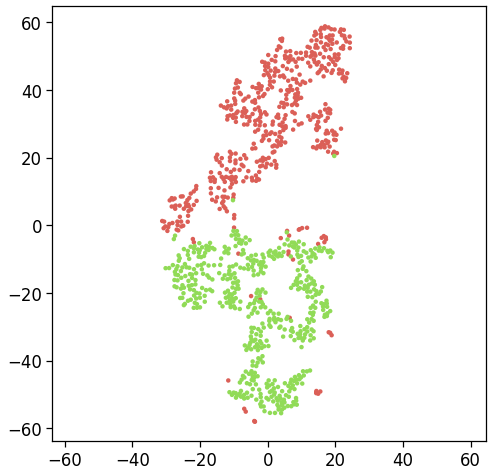

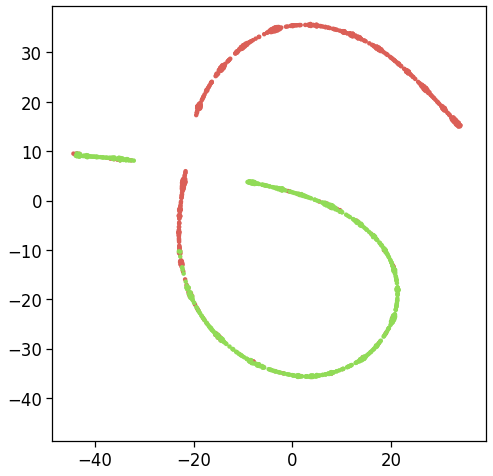

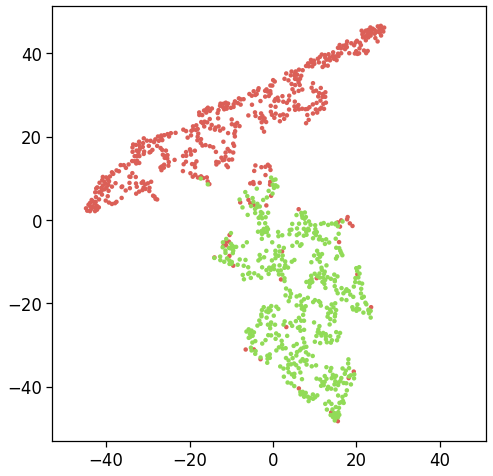

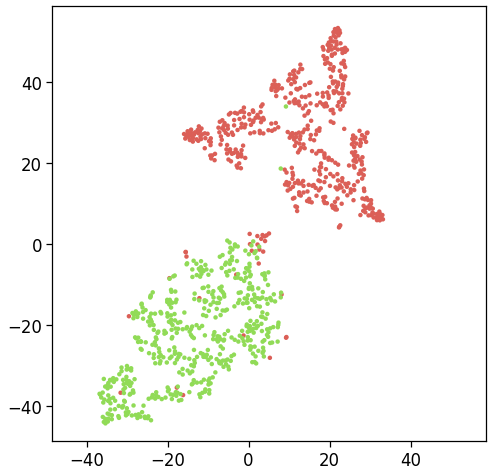

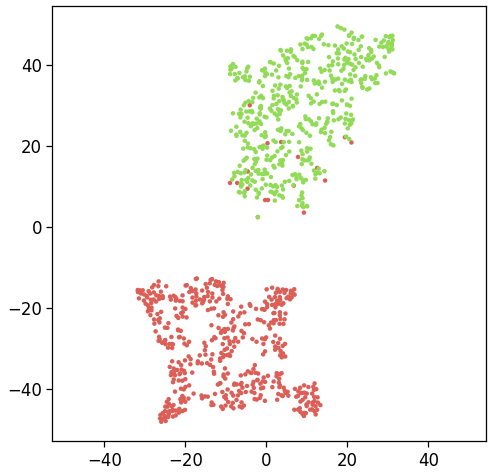

In [ ]:
# initialized posterior per episode
color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])
for i in range(5):
    item_pri = np.array(priors[1])[:,i,:]
    item_post = np.array(posts[1])[:,i,:]
    item = np.concatenate((item_pri,item_post), axis=0)
    item.shape
    myprint(item, color)

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2919264/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/env

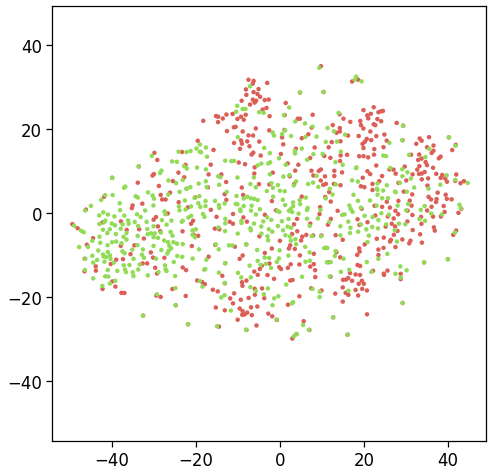

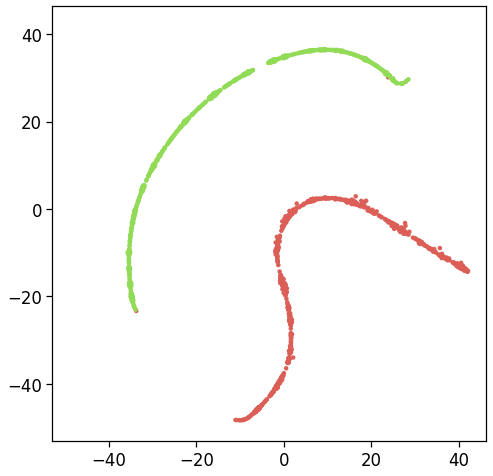

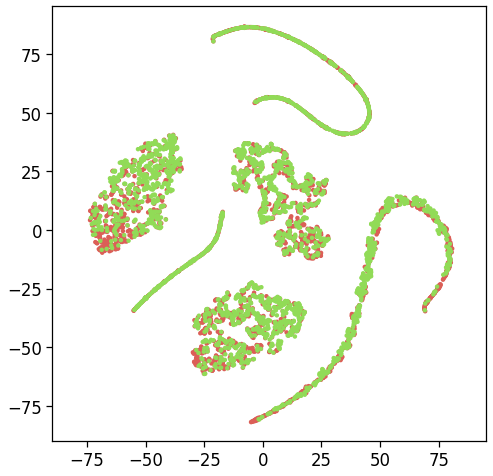

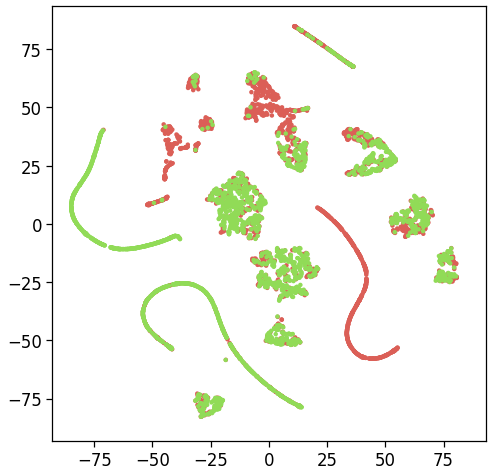

In [ ]:
import numpy as np

color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])

# #first dim only
# item_pri = [i.numpy()[0] for i in priors]
# item_post = [i.numpy()[0] for i in posts]

# item = np.array(item_pri+item_post)
# item.shape
# myprint(item, color)

# #avg 
# item_pri = [np.mean(i,axis=0) for i in priors]
# item_post = [np.mean(i,axis=0) for i in posts]

# item = np.array(item_pri+item_post)
# item.shape
# myprint(item, color)

#ori 
item_pri = [np.reshape(i, [-1]) for i in priors[0]]
item_post = [np.reshape(i, [-1]) for i in posts[0]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)

item_pri = [np.reshape(i, [-1]) for i in priors[1]]
item_post = [np.reshape(i, [-1]) for i in posts[1]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)

# arg
# item_pri = [np.reshape(i, [-1]) for i in priors_args[0]]
# item_post = [np.reshape(i, [-1]) for i in posts_args[0]]
# item = np.array(item_pri+item_post)
# item.shape
# myprint(item, color)

# item_pri = [np.reshape(i, [-1]) for i in priors_args[1]]
# item_post = [np.reshape(i, [-1]) for i in posts_args[1]]
# item = np.array(item_pri+item_post)
# item.shape
# myprint(item, color)

color = np.array([0 for i in priors[0]]*5+[1 for i in priors[0]]*5)
item_pri = np.reshape(np.array(priors[0]), [-1,8])
item_post = np.reshape(np.array(posts[0]), [-1,8])
item = np.concatenate((item_pri,item_post), axis=0)
item.shape
myprint(item, color)


item_pri = np.reshape(np.array(priors[1]), [-1,8])
item_post = np.reshape(np.array(posts[1]), [-1,8])
item = np.concatenate((item_pri,item_post), axis=0)
item.shape
myprint(item, color)


/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2919264/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/env

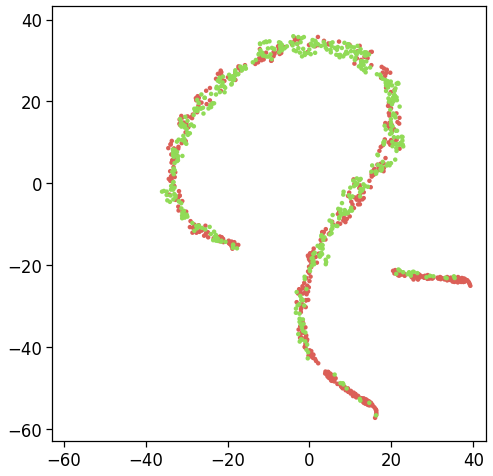

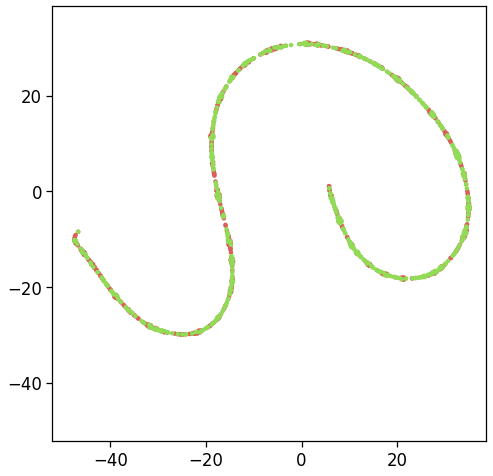

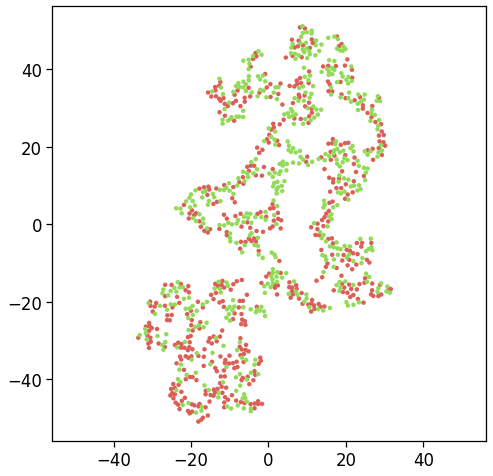

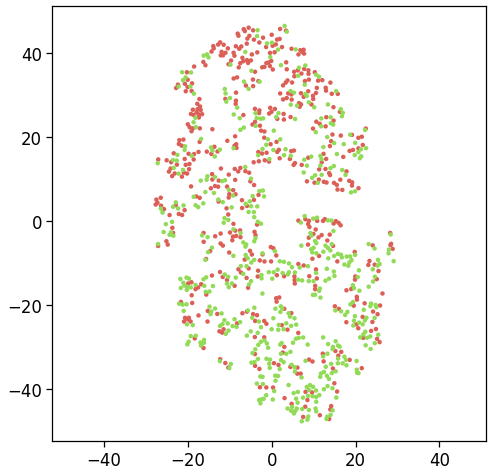

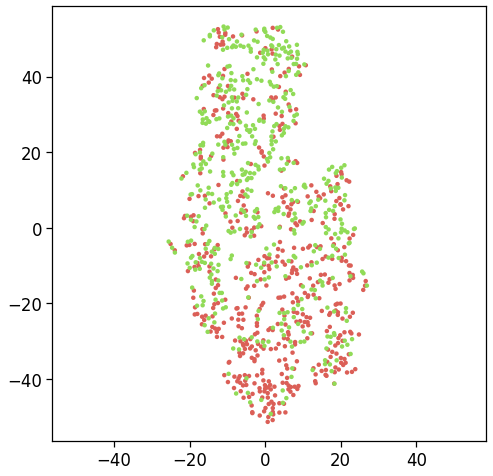

In [ ]:
# original per episode
color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])
for i in range(5):
    item_pri = np.array(priors[0])[:,i,:]
    item_post = np.array(posts[0])[:,i,:]
    item = np.concatenate((item_pri,item_post), axis=0)
    item.shape
    myprint(item, color)

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2919264/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/env

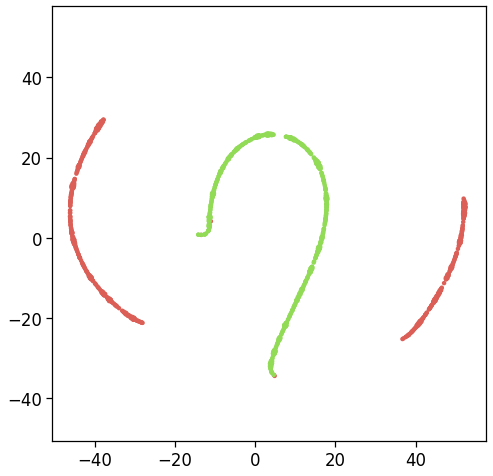

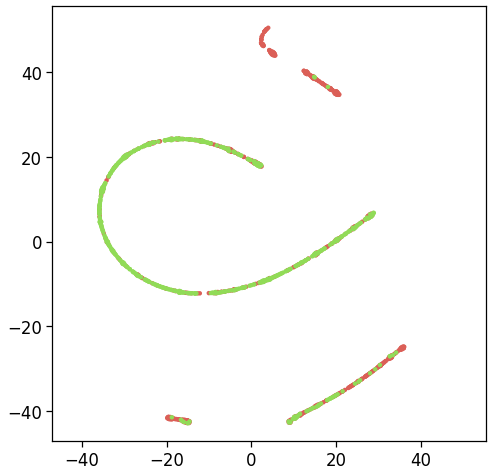

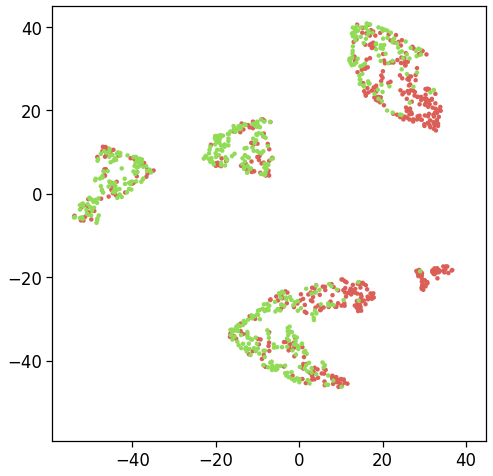

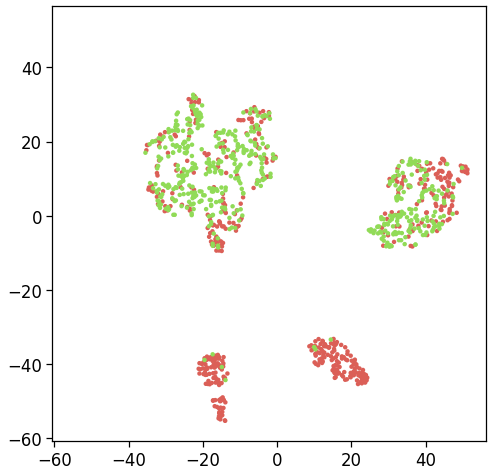

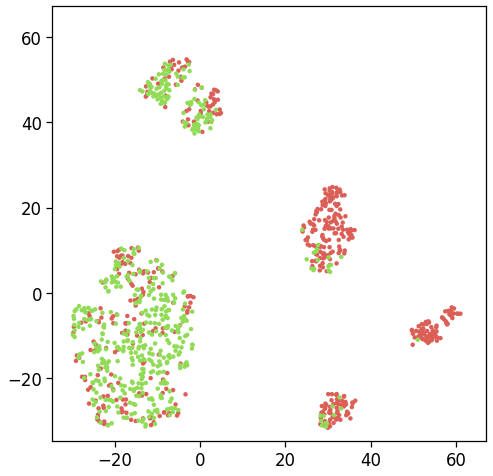

In [ ]:
# kg-enhanced per episode
color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])
for i in range(5):
    item_pri = np.array(priors[1])[:,i,:]
    item_post = np.array(posts[1])[:,i,:]
    item = np.concatenate((item_pri,item_post), axis=0)
    item.shape
    myprint(item, color)


/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_50176/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/envs/

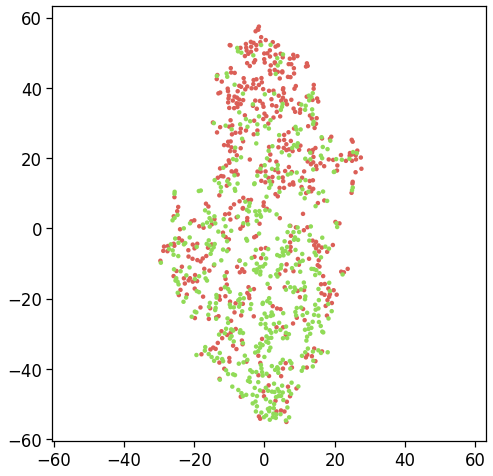

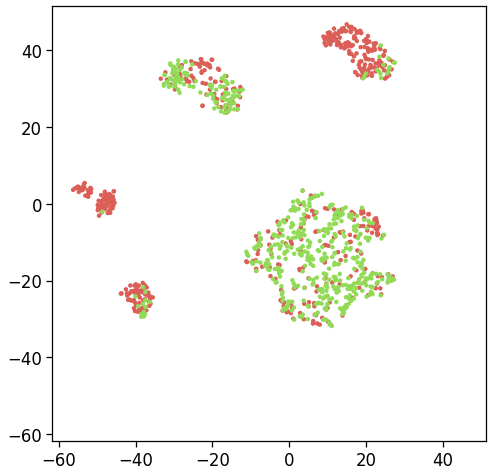

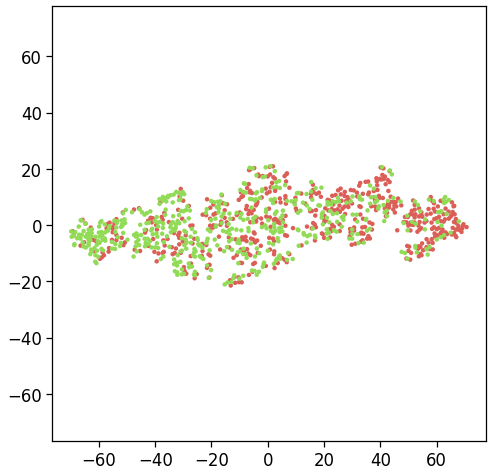

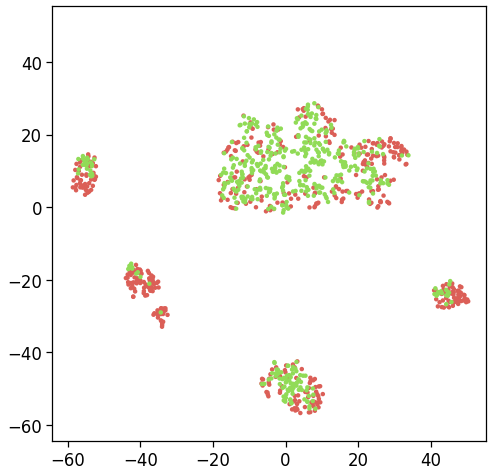

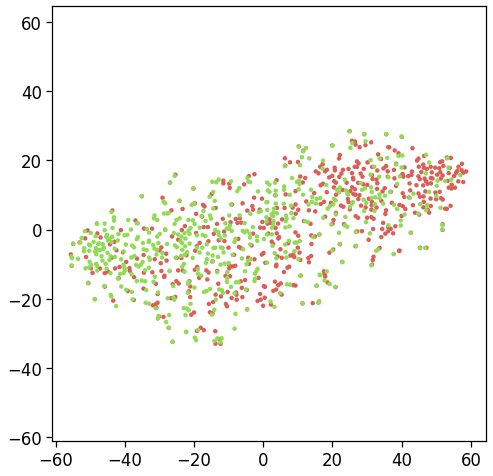

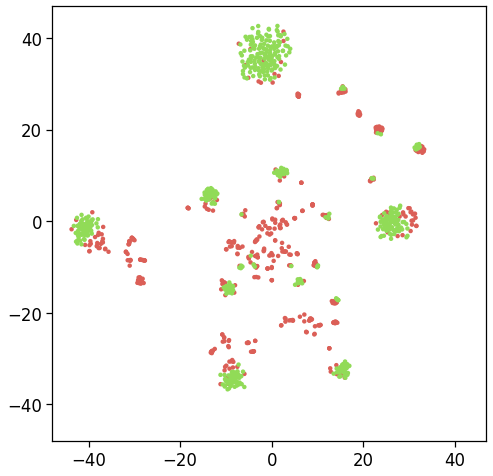

In [9]:
# Compare last three epis
import numpy as np

color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])

# #first dim only
# item_pri = [i.numpy()[0] for i in priors[0]]
# item_post = [i.numpy()[0] for i in posts[0]]

# item = np.array(item_pri+item_post)
# item.shape
# myprint(item, color)

#last epi only
item_pri = [i.numpy()[-1] for i in priors[0]]
item_post = [i.numpy()[-1] for i in posts[0]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)


item_pri = [i.numpy()[-1] for i in priors[1]]
item_post = [i.numpy()[-1] for i in posts[1]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)

# #avg 
item_pri = [np.mean(i[2:],axis=0) for i in priors[0]]
item_post = [np.mean(i[2:],axis=0) for i in posts[0]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)
item_pri = [np.mean(i[2:],axis=0) for i in priors[1]]
item_post = [np.mean(i[2:],axis=0) for i in posts[1]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)


#ori 
# item_pri = [np.reshape(i, [-1]) for i in priors[0]]
# item_post = [np.reshape(i, [-1]) for i in posts[0]]



# last three
item_pri = [np.reshape(i,[-1]) for i in np.array(priors[0])[:,2:,:]]
item_post = [np.reshape(i,[-1]) for i in np.array(posts[0])[:,2:,:]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)

item_pri = [np.reshape(i,[-1]) for i in np.array(priors[1])[:,2:,:]]
item_post = [np.reshape(i,[-1]) for i in np.array(posts[1])[:,2:,:]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color)

In [ ]:
np.array(priors[0])[:,-1,:].shape

(500, 8)

In [ ]:
def softmax(x):
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

ori_0 = np.array(priors[0])[:,-1,:]
ori_0 = np.array(priors[0])[:,-1,:]
ori_0_sf = softmax(ori_0)

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_2919264/2919293721.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])
/home/faan/anaconda3/env

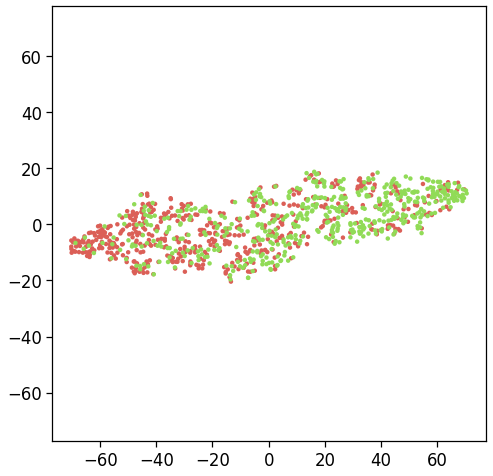

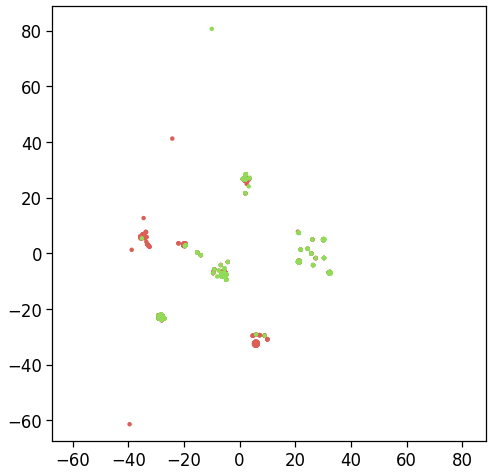

In [ ]:
# last three
item_pri = softmax(np.array(priors[0])[:,-1,:])
item_post = softmax(np.array(posts[0])[:,-1,:])
item = np.concatenate((item_pri,item_post))
item.shape
myprint(item, color)

item_pri = softmax(np.array(priors[1])[:,-1,:])
item_post = softmax(np.array(posts[1])[:,-1,:])
item = np.concatenate((item_pri,item_post))
item.shape
myprint(item, color)


In [ ]:
# item = np.array(priors_args[0]+posts_args[0])
# item.shape
# myprint(item, color)

# item = np.array(priors_args[1]+posts_args[1])
# item.shape
# myprint(item, color)

# item = np.array(priors_args[0]+priors_args[1])
# item.shape
# myprint(item, color)

# item = np.array(posts_args[0]+posts_args[1])
# item.shape
# myprint(item, color)

import pandas as pd
# pd.set_option('display.max_rows',None)
pd.DataFrame(np.concatenate((np.array(priors_args[0]),np.array(posts_args[0])),axis=1))

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,2,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,4,0,0,0,1
4,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,2,1,0,0,0
496,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,2,0,0,0,0


In [ ]:
pd.DataFrame(np.concatenate((np.array(priors_args[1]),np.array(posts_args[1])),axis=1))

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,2,0,0,0,0
1,0,0,0,0,0,4,0,0,0,0
2,0,0,0,0,0,4,0,0,0,0
3,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,4,0,0,0,0
496,0,0,0,0,0,2,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,4,0,0,0,0


In [ ]:
example['knowledge_kg_masks']

<tf.Tensor: shape=(1, 5, 8, 25), dtype=int32, numpy=
array([[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_50176/1827289121.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])


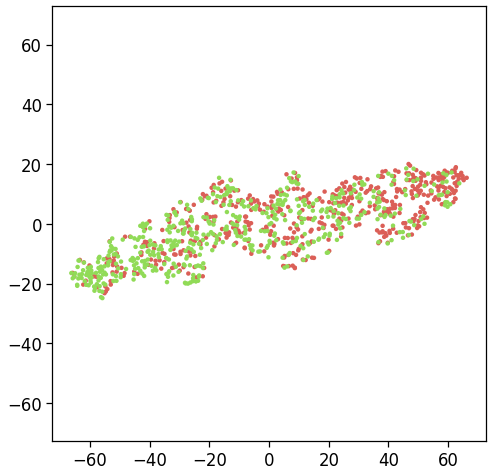

/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/faan/anaconda3/envs/tf27py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_50176/1827289121.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[colors.astype(np.int)])


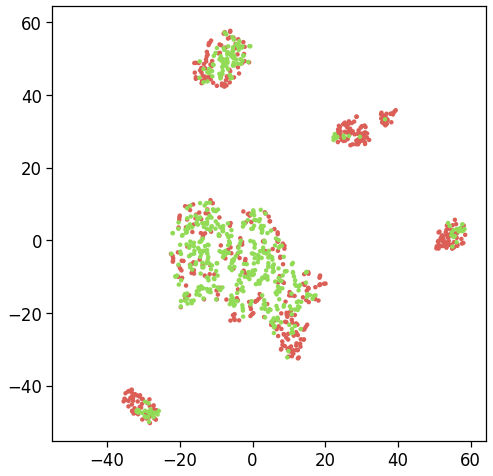

In [17]:
# temp 0331
# Compare last three epis
import numpy as np

color = np.array([0 for i in priors[0]]+[1 for i in priors[0]])

# #avg 
item_pri = [np.mean(i[2:],axis=0) for i in priors[0]]
item_post = [np.mean(i[2:],axis=0) for i in posts[0]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color, 'skt')
item_pri = [np.mean(i[2:],axis=0) for i in priors[1]]
item_post = [np.mean(i[2:],axis=0) for i in posts[1]]
item = np.array(item_pri+item_post)
item.shape
myprint(item, color, 'sktkg')
